In [67]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [33]:
fpath = 'facebook_data_washingtonpost_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,10161064302597293,2021-06-13 16:01:36.194976,Most Brazilians don’t want it. Major sponsors ...,42,7,1.750,0.00,15.250,1.750,...,23,-0.043478,0,1,23,-0.043478,0.152,0.000,0.848,0.6928
1,2,10161064491792293,2021-06-13 15:31:36.998794,"""Revenge bedtime procrastination"" rose with th...",155,30,0.500,0.50,12.000,0.000,...,18,-0.166667,0,2,18,-0.111111,0.000,0.172,0.828,-0.6808
2,3,10161064295582293,2021-06-13 14:31:38.084890,"The TSA screened 2 million people Friday, the ...",78,6,0.000,0.00,14.000,0.000,...,12,0.000000,0,0,12,0.000000,0.000,0.000,1.000,0.0000
3,4,10161064362427293,2021-06-13 09:31:39.017490,A world where billionaires are impossible: Doe...,1000,98,0.125,2.25,9.625,-2.125,...,17,-0.058824,0,2,17,-0.117647,0.113,0.000,0.887,0.5514
4,5,10161064370072293,2021-06-13 08:31:39.890156,President Biden has been greeted at the G-7 su...,431,24,1.500,1.00,16.500,0.500,...,24,0.041667,0,1,24,-0.041667,0.162,0.136,0.702,0.3182


In [34]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

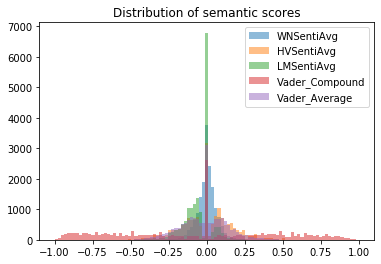

In [35]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

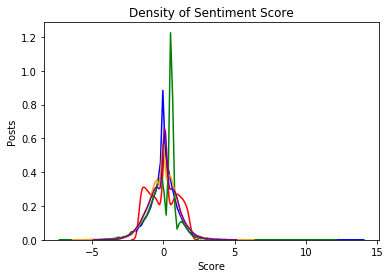

In [37]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Density of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [38]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000
mean,0.001639,0.001228,-0.049969,-0.067566,-0.016351
std,0.063697,0.168456,0.089506,0.527206,0.149915
min,-0.437500,-1.000000,-0.666667,-0.992500,-0.684000
25%,-0.028846,-0.101282,-0.100000,-0.526700,-0.111000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.034091,0.105263,0.000000,0.371150,0.078000
max,0.875000,1.000000,1.000000,0.984100,0.689000


In [39]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [40]:
post_data['DateMonth'].head()

0    2021-06
1    2021-06
2    2021-06
3    2021-06
4    2021-06
Name: DateMonth, dtype: object

In [41]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [42]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [43]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [44]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [45]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2012-06-06,0.195489,5,0.22840,0.053600,8,9,75,2,4,75,0.039098,-0.013333,-0.026667
2012-06-07,0.222966,5,0.46806,0.148600,12,1,56,1,0,56,0.044593,0.196429,0.017857
2012-06-08,-0.089240,5,0.16512,0.029000,9,5,69,0,3,69,-0.017848,0.057971,-0.043478
2012-06-09,0.035545,8,0.29615,0.074875,20,13,131,2,10,131,0.004443,0.053435,-0.061069
2012-06-10,-0.149351,5,-0.17534,-0.065600,8,6,77,3,6,77,-0.029870,0.025974,-0.038961


In [46]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -14.0856
p-value                           0.0000
#Lags Used                        7.0000
Number of Observations Used    2191.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64


In [47]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -31.1863
p-value                           0.0000
#Lags Used                        1.0000
Number of Observations Used    2197.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64


In [48]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -31.1863
p-value                           0.0000
#Lags Used                        1.0000
Number of Observations Used    2197.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64
Results of Dickey-Fuller Test:


In [49]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.4573
p-value                           0.0000
#Lags Used                       17.0000
Number of Observations Used    2181.0000
Critical Value (1%)              -3.4334
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64
Results of Dickey-Fuller Test:


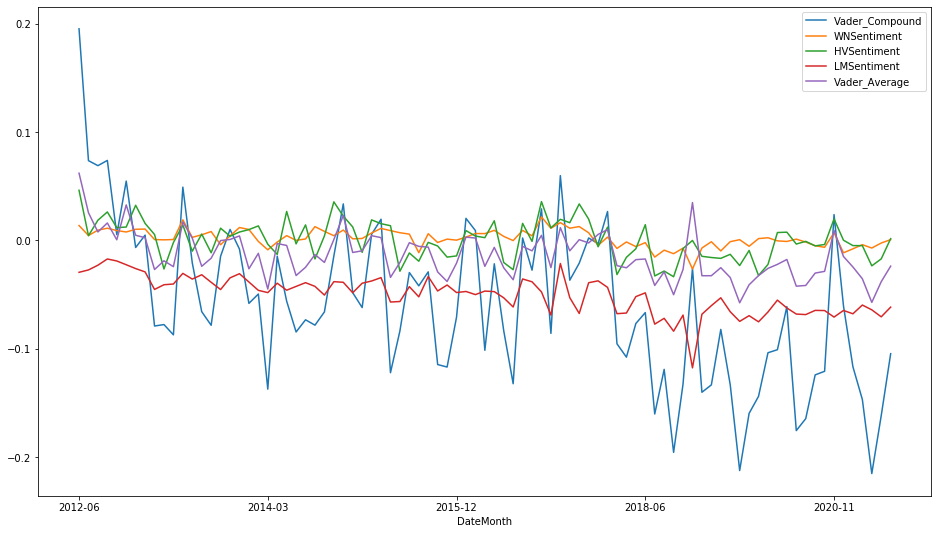

In [50]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [51]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [52]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [53]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [54]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [66]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [55]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [56]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [57]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [58]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2012-06,1363.459961,1266.739990,1309.869995,1362.160034,81582440000,1362.160034,0.038793,1.982956,144,0.195397,0.062083,247,151,2073,28,89,2073,0.013771,0.046310,-0.029426
2012-07,1391.739990,1325.410034,1362.329956,1379.319946,73103810000,1379.319946,0.012519,0.928850,203,0.073673,0.025581,327,312,3416,41,134,3416,0.004576,0.004391,-0.027225
2012-08,1426.680054,1354.650024,1379.319946,1406.579956,70283810000,1406.579956,0.019571,1.911655,201,0.069049,0.007846,381,314,3588,45,127,3588,0.009511,0.018673,-0.022854
2012-09,1474.510010,1396.560059,1406.540039,1440.670044,69784280000,1440.670044,0.023947,1.433716,127,0.073886,0.016118,276,213,2396,49,90,2396,0.011289,0.026294,-0.017112
2012-10,1470.959961,1403.280029,1440.900024,1412.160034,71752320000,1412.160034,-0.019988,1.159520,127,0.005295,0.000606,240,215,2111,37,77,2111,0.009130,0.011843,-0.018948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068,0.036449,-2.833400,248,-0.060378,-0.014806,656,655,4750,71,378,4750,-0.011425,0.000211,-0.064632
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,-2.796821,362,-0.116635,-0.024497,1023,1057,7148,95,579,7148,-0.007726,-0.004757,-0.067711
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,-1.932286,496,-0.146813,-0.035369,1255,1299,9155,128,674,9155,-0.003896,-0.004806,-0.059640
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,-0.231207,33,-0.215218,-0.057182,76,91,640,4,45,640,-0.007006,-0.023438,-0.064062


In [69]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0676  , p=0.7948  , df_denom=1491, df_num=1
ssr based chi2 test:   chi2=0.0678  , p=0.7946  , df=1
likelihood ratio test: chi2=0.0678  , p=0.7946  , df=1
parameter F test:         F=0.0676  , p=0.7948  , df_denom=1491, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1443  , p=0.8657  , df_denom=1488, df_num=2
ssr based chi2 test:   chi2=0.2895  , p=0.8652  , df=2
likelihood ratio test: chi2=0.2895  , p=0.8652  , df=2
parameter F test:         F=0.1443  , p=0.8657  , df_denom=1488, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1156  , p=0.9510  , df_denom=1485, df_num=3
ssr based chi2 test:   chi2=0.3485  , p=0.9507  , df=3
likelihood ratio test: chi2=0.3485  , p=0.9507  , df=3
parameter F tes

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5518  , p=0.4577  , df_denom=1491, df_num=1
ssr based chi2 test:   chi2=0.5529  , p=0.4571  , df=1
likelihood ratio test: chi2=0.5528  , p=0.4572  , df=1
parameter F test:         F=0.5518  , p=0.4577  , df_denom=1491, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3114  , p=0.7325  , df_denom=1488, df_num=2
ssr based chi2 test:   chi2=0.6249  , p=0.7316  , df=2
likelihood ratio test: chi2=0.6248  , p=0.7317  , df=2
parameter F test:         F=0.3114  , p=0.7325  , df_denom=1488, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2973  , p=0.8273  , df_denom=1485, df_num=3
ssr based chi2 test:   chi2=0.8962  , p=0.8263  , df=3
likelihood ratio test: chi2=0.8959  , p=0.8264  , df=3
parameter F test:         F=0.29

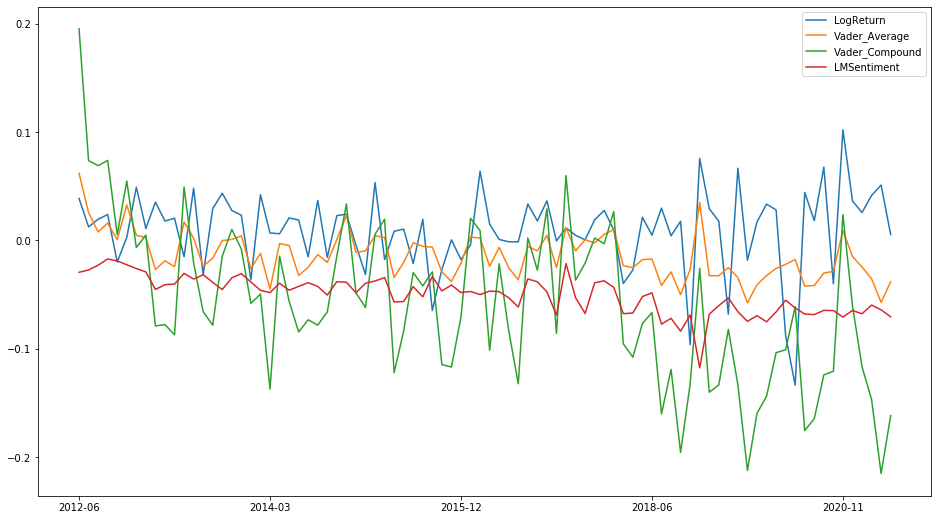

In [64]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound','LMSentiment']].plot(legend=True, figsize=(16,9))

In [70]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.935980,0.374097,0.530864,0.503469,0.010417
Vader_Average,0.935980,1.000000,0.396339,0.511508,0.481525,0.012122
WNSentiment,0.374097,0.396339,1.000000,0.266188,0.263376,-0.014565
HVSentiment,0.530864,0.511508,0.266188,1.000000,0.452049,0.007531
LMSentiment,0.503469,0.481525,0.263376,0.452049,1.000000,-0.014845
LogReturn,0.010417,0.012122,-0.014565,0.007531,-0.014845,1.000000


In [72]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.738459
Vader_Average   0.678064
WNSentiment     0.526620
HVSentiment     0.764422
LMSentiment     0.545547


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369


In [ ]:
                 p-value
Vader_Compound  0.738459
Vader_Average   0.678064
WNSentiment     0.526620
HVSentiment     0.764422
LMSentiment     0.545547